In [1]:
import sys
sys.path.append( '../utilities' )
from data_engine import DataEngine
from backtesting import Backtesting
from custom_indicators import CustomIndocators as ci
import pandas as pd
import ta
import ccxt
import json

In [22]:
# pairList = pairJson['hitbtc2018']
pair = 'BTC/USDT'
timeframe = '15m'
startDate = '2017-01-01T00:00:00'

dataEngine = DataEngine(session=ccxt.binance(), path_to_data='../database/')

df = dataEngine.get_historical_from_db(pair, timeframe, startDate)

Successfully load 154332 candles for BTCUSDT


In [29]:
# -- Indicator variable --
volume_window = 10
willWindow = 14

# -- Drop all columns we do not need --
df.drop(columns=df.columns.difference(['open','high','low','close','volume']), inplace=True)

# -- Indicators, you can edit every value --
df['VOL_ANO'] = ci.volume_anomality(df, volume_window)
df['MIN20'] = df['close'].rolling(20).min()
df['WillR'] = ta.momentum.williams_r(high=df['high'], low=df['low'], close=df['close'], lbp=willWindow)
df['CANDLE_DIFF'] = abs(df['open'] - df['close'])
df['MEAN_DIFF'] = df['CANDLE_DIFF'].rolling(10).mean()

print("Indicators loaded 100%")

# -- Uncomment the line below if you want to check your dataset with indicators --
df

Indicators loaded 100%


,open,high,low,close,volume,VOL_ANO,MIN20,WillR,CANDLE_DIFF,MEAN_DIFF
timestamp,,,,,,,,,,
2017-08-17 04:00:00,4261.48,4280.56,4261.48,4261.48,2.189061,0,NaN,NaN,0.00,NaN
2017-08-17 04:15:00,4261.48,4270.41,4261.32,4261.45,9.119865,0,NaN,NaN,0.03,NaN
2017-08-17 04:30:00,4280.00,4310.07,4267.99,4310.07,21.923552,0,NaN,NaN,30.07,NaN
2017-08-17 04:45:00,4310.07,4313.62,4291.37,4308.83,13.948531,0,NaN,NaN,1.24,NaN
2017-08-17 05:00:00,4308.83,4328.69,4304.31,4304.31,5.101153,0,NaN,NaN,4.52,NaN
...,...,...,...,...,...,...,...,...,...,...
2022-01-16 13:00:00,43005.93,43026.08,42891.58,42974.01,349.059450,0,42850.47,-49.612149,31.92,68.931
2022-01-16 13:15:00,42974.01,42974.01,42581.79,42610.13,845.122340,-3,42610.13,-95.307325,363.88,84.380
2022-01-16 13:30:00,42610.14,43013.36,42590.14,42980.39,547.913840,1,42610.13,-33.997881,370.25,116.452


In [36]:
# -- Intern parameter --
# dfTest = df['2017-10-24':'2018-01-31']
dfTest = df['2021':]
startingBalance = 1000
makerFee = 0.0002
takerFee = 0.0007
# takerFee = 0

# -- Rules --
StopLossActivation = False
takeProfitActivation = False
timeLimitActivation = False
showLog = False
waitNextSignal = False

# -- Hyper parameters --
willROverBought = -20
SlPct = 0.02
TpPct = 0.02
timeLimit = 17


# -- Trade Functions --
# -- Condition to BUY market --

def buyCondition(row, previousRow):
    if (
        row['VOL_ANO'] > 0
        and previousRow['VOL_ANO'] < 0
        and previousRow['close'] <= previousRow['MIN20']
        and previousRow['CANDLE_DIFF'] > row['CANDLE_DIFF']
        and (previousRow['open'] - previousRow['close']) > 0.0025 * row['close']
    ):
        return True
    else:
        return False

# -- Condition to SELL market --


def sellCondition(row, previousRow):
    if (
        row['WillR'] > willROverBought
    ):
        return True
    else:
        return False


# -- Value initialisation --
usd = startingBalance
wallet = startingBalance
coin = 0
lastAth = 0
previousRow = dfTest.iloc[0]
stopLoss = 0
takeProfit = 500000
buyReady = True
sellReady = True
currentTimeOpen = 0
timeSince = 0

# -- Definition of dfTrades, that will be the dataset to do your trades analyses --
dfTrades = None
dfTrades = pd.DataFrame(columns=['date', 'position', 'reason',
                                 'price', 'frais', 'fiat', 'coins', 'wallet', 'timeSince'])

# -- Iteration on all your price dataset (df) --
for index, row in dfTest.iterrows():
    timeSince += 1
    if currentTimeOpen > 0:
        currentTimeOpen += 1
    # -- Buy market order --
    if buyCondition(row, previousRow) and usd > 0 and buyReady == True:
        # -- You can define here at what price you buy --
        buyPrice = row['close']

        # -- Define the price of you SL and TP or comment it if you don't want a SL or TP --
        if StopLossActivation:
            stopLoss = buyPrice - SlPct * buyPrice
        if takeProfitActivation:
            takeProfit = buyPrice + TpPct * buyPrice
        if timeLimitActivation:
            currentTimeOpen = 1

        fee = takerFee * usd
        usd = usd - fee
        coin = usd / buyPrice
        usd = 0
        wallet = coin * row['close']

        if showLog:
            print("Buy COIN at", buyPrice, '$ the', index)

        # -- Add the trade to dfTrades to analyse it later --
        myrow = {
            'date': index,
            'position': "Buy",
            'reason': 'Buy Market Order',
            'price': buyPrice,
            'frais': fee,
            'fiat': usd,
            'coins': coin,
            'wallet': wallet,
            'timeSince': timeSince
        }
        dfTrades = dfTrades.append(myrow, ignore_index=True)
        timeSince = 0

    # -- Take Profit --
    elif row['high'] > takeProfit and coin > 0:
        sellPrice = takeProfit
        usd = coin * sellPrice
        fee = makerFee * usd
        usd = usd - fee
        coin = 0
        wallet = usd

        if waitNextSignal:
            buyReady = False

        # -- You can uncomment the line below if you want to see logs --
        if showLog:
            print("Sell COIN at Take Profit", sellPrice, '$ the', index)

        # -- Add the trade to dfTrades to analyse it later --
        myrow = {
            'date': index,
            'position': "Sell",
            'reason': 'Sell Take Profit',
            'price': sellPrice,
            'frais': fee,
            'fiat': usd,
            'coins': coin,
            'wallet': wallet,
            'timeSince': timeSince
        }
        dfTrades = dfTrades.append(myrow, ignore_index=True)
        timeSince = 0
    # -- Stop Loss --
    elif row['low'] < stopLoss and coin > 0:
        sellPrice = stopLoss
        usd = coin * sellPrice
        fee = makerFee * usd
        usd = usd - fee
        coin = 0
        wallet = usd

        currentTimeOpen = 0

        if waitNextSignal:
            buyReady = False

        # -- You can uncomment the line below if you want to see logs --
        if showLog:
            print("Sell COIN at Stop Loss", sellPrice, '$ the', index)
        # -- Add the trade to dfTrades to analyse it later --
        myrow = {
            'date': index,
            'position': "Sell",
            'reason': 'Sell Stop Loss',
            'price': sellPrice,
            'frais': fee,
            'fiat': usd,
            'coins': coin,
            'wallet': wallet,
            'timeSince': timeSince
        }
        dfTrades = dfTrades.append(myrow, ignore_index=True)
        timeSince = 0

    # -- Sell Market Order --
    elif sellCondition(row, previousRow):
        buyReady = True
        if coin > 0:
            # -- You can define here at what price you buy --
            sellPrice = row['close']
            usd = coin * sellPrice
            fee = takerFee * usd
            usd = usd - fee
            coin = 0
            # buyReady = True
            wallet = usd

            # -- You can uncomment the line below if you want to see logs --
            if showLog:
                print("Sell COIN at", sellPrice, '$ the', index)

            # -- Add the trade to DfTrades to analyse it later --
            myrow = {
                'date': index,
                'position': "Sell",
                'reason': 'Sell Market Order',
                'price': sellPrice,
                'frais': fee,
                'fiat': usd,
                'coins': coin,
                'wallet': wallet,
                'timeSince': timeSince
            }
            dfTrades = dfTrades.append(myrow, ignore_index=True)
            timeSince = 0

    elif currentTimeOpen > timeLimit and coin > 0:
        sellPrice = row['close']
        usd = coin * sellPrice
        fee = takerFee * usd
        usd = usd - fee
        coin = 0
        if waitNextSignal:
            buyReady = False
        wallet = usd

        # -- You can uncomment the line below if you want to see logs --
        if showLog:
            print("Sell COIN at", sellPrice, '$ the', index)

        # -- Add the trade to DfTrades to analyse it later --
        myrow = {
            'date': index,
            'position': "Sell",
            'reason': 'Sell Time Market Order',
            'price': sellPrice,
            'frais': fee,
            'fiat': usd,
            'coins': coin,
            'wallet': wallet,
            'timeSince': timeSince
        }
        dfTrades = dfTrades.append(myrow, ignore_index=True)
        timeSince = 0
    previousRow = row

print("Final wallet", wallet)


Final wallet 1043.0257404239126


In [40]:
dfTrades.iloc[-20:]

,date,position,reason,price,frais,fiat,coins,wallet,timeSince
298,2021-12-26 00:00:00,Buy,Buy Market Order,50420.00,0.700697,0,0.019839,1000.295075,245
299,2021-12-26 07:45:00,Sell,Sell Market Order,49930.39,0.693407,989.888172,0.000000,989.888172,31
300,2021-12-27 09:00:00,Buy,Buy Market Order,50630.12,0.692922,0,0.019538,989.195250,101
301,2021-12-27 12:15:00,Sell,Sell Market Order,50856.96,0.695539,992.931639,0.000000,992.931639,13
302,2022-01-01 10:30:00,Buy,Buy Market Order,46979.50,0.695052,0,0.021121,992.236587,473
303,2022-01-01 16:00:00,Sell,Sell Market Order,47428.34,0.701201,1001.015169,0.000000,1001.015169,22
304,2022-01-03 20:30:00,Buy,Buy Market Order,45788.42,0.700711,0,0.021846,1000.314458,210
305,2022-01-03 23:15:00,Sell,Sell Market Order,46410.00,0.709726,1013.184049,0.000000,1013.184049,11
306,2022-01-06 04:00:00,Buy,Buy Market Order,43026.14,0.709229,0,0.023532,1012.474820,211
307,2022-01-06 07:00:00,Sell,Sell Market Order,43142.12,0.710643,1014.493375,0.000000,1014.493375,12


In [37]:
BTobject = Backtesting()
newDf = BTobject.simple_spot_backtest_analys(dfTrades=dfTrades, dfTest=dfTest, pairSymbol=pair, timeframe=timeframe)

Pair Symbol : BTC/USDT | Timeframe : 15m
Period : [2021-01-01 00:00:00] -> [2022-01-16 14:00:00]
Starting balance : 999.3 $

----- General Informations -----
Final balance : 1043.03 $
Performance vs US Dollar : 4.38 %
Buy and Hold Performence : 50.41 %
Performance vs Buy and Hold : -30.61 %
Best trade : +5.52 %, the 2021-05-20 02:30:00
Worst trade : -9.01 %, the 2021-12-04 08:30:00
Worst drawDown : - 22.29 %
Total fees :  217.09 $

----- Trades Informations -----
Total trades on period : 159
Number of positive trades : 107
Number of negative trades :  52
Trades win rate ratio : 67.3 %
Average trades performance : 0.11 %
Average positive trades : 1.08 %
Average negative trades : -1.87 %

----- Time Informations -----
Average time duration for a trade : 17.57 periods
Maximum time duration for a trade : 45 periods
Minimum time duration for a trade : 1 periods
Average time duration between two trades : 211.22 periods
Maximum time duration between two trades : 1356 periods
Minimum time dura


----- Plot -----


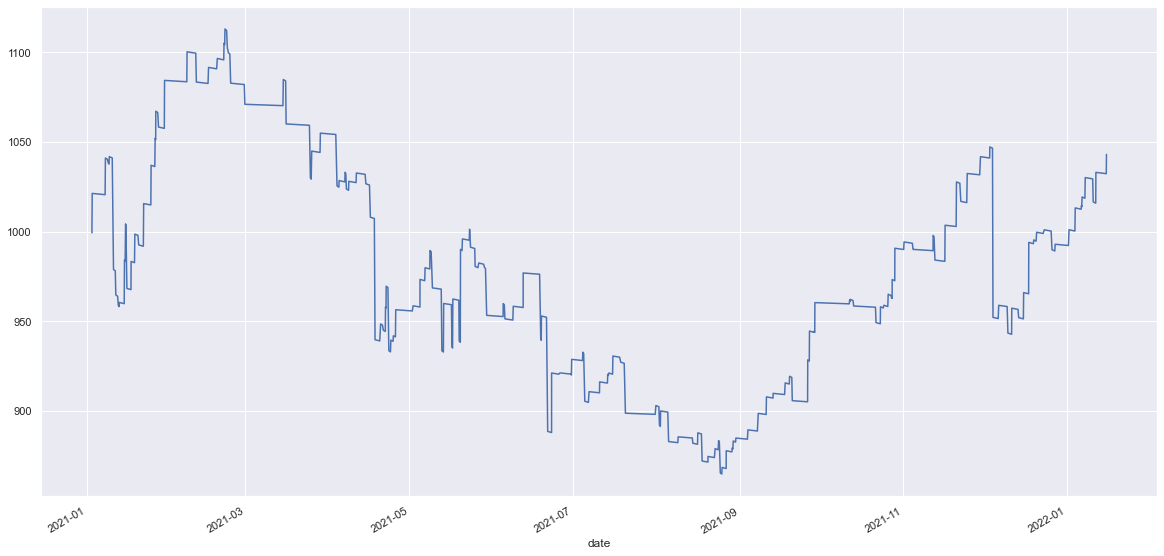

In [38]:
BTobject.plot_wallet_evolution(dfTrades=newDf)